<a href="https://colab.research.google.com/github/aditipatil0711/SJSU_Masters_Assignments/blob/main/CMPE255_Data_Mining/Assignment4/Part3/Apache_Beam_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experimenting with Apache Beam Features**

The following are the features of Apache Beam:
* **Composite Transform**: In Apache Beam, a composite transform is a combination of multiple transforms (which can be primitive or other composite transforms) bundled together to create a reusable component.

* **Pipeline IO:** This refers to reading from and writing to external data sources using Apache Beam pipelines. Examples include reading from Google Cloud Storage, BigQuery, and other data sources, and writing the processed results back to them.

* **Triggers:** In Apache Beam, a trigger determines when to produce results for a specific window. They can be based on the number of elements, processing time, event time, etc.

* **Windowing:** Windowing splits the infinite stream of data into finite chunks or "windows". Apache Beam provides several types of windowing strategies such as fixed windows, sliding windows, and session windows.

* **ParDo:** ParDo is a parallel processing operation in Apache Beam. It stands for "Parallel Do". It allows you to perform a custom transformation on each element in the input collection.





## Step 1: Dataset
Let's use a simple dataset with timestamps, user events, and some associated values:

In [ ]:
data = """
timestamp, event, value
2023-10-23 10:00:00, login, 5
2023-10-23 10:01:00, logout, 3
2023-10-23 10:02:00, purchase, 20
2023-10-23 10:03:00, login, 7
2023-10-23 10:04:00, purchase, 15
"""

with open("events.csv", "w") as file:
    file.write(data)

## Step 2: Setup Apache Beam in Colab
First, we need to set up Apache Beam in a Colab environment.

In [ ]:
!pip install apache-beam[interactive]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.0/807.0 kB 42.9 M

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.transforms.window import FixedWindows
from apache_beam.transforms import WindowInto
from apache_beam.transforms.trigger import AfterCount, Repeatedly


## Step 3: Create the Pipeline
 For every feature, the following has been done:
1. **Pipeline IO:** Use ReadFromText to read the CSV data and WriteToText to output the results.
2. **Windowing:** Use FixedWindows to divide the dataset into fixed intervals.
3. **ParDo:** Create a custom DoFn to process each record. For this exercise, let's extract the event and its associated value.
4. **Composite Transform:** Combine multiple transforms. As an example, after extracting the event and its value, let's calculate the sum of values for each event type.
5. **Triggers:** For demonstration purposes, set a trigger to output results after each window is processed.

### *ParDo Function*

In [ ]:
 # ParDo function to extract event and its associated value
class ExtractEventValueFn(beam.DoFn):
   def process(self, element):
        parts = element.split(',')
        if len(parts) == 3:
            _, event, value = parts
            yield (event.strip(), int(value.strip()))

### *Composite Transform*

In [ ]:
 #Composite transform to extract event and calculate sum of values
class ExtractAndSumValues(beam.PTransform):
    def expand(self, pcoll):
        return (
            pcoll
            | 'ExtractEventValue' >> beam.ParDo(ExtractEventValueFn())
            | 'SumValues' >> beam.CombinePerKey(sum)
        )

### *Running the Pipeline*

In [ ]:
# Define the pipeline
def run_pipeline():
    # Set up the pipeline options
    options = PipelineOptions()
    p = beam.Pipeline(options=options)

    # Read from the input file
    events = (
        p
        | 'ReadFromFile' >> ReadFromText('events.csv')
        | 'SkipHeader' >> beam.Filter(lambda x: not x.startswith('timestamp'))
        | 'WindowInto1MinWithTrigger' >> beam.WindowInto(FixedWindows(60), trigger=Repeatedly(AfterCount(2)), accumulation_mode=beam.transforms.trigger.AccumulationMode.DISCARDING)

    )

    # Apply the composite transform
    processed_events = events | 'ProcessEvents' >> ExtractAndSumValues()

    # Write to the output file
    processed_events | 'WriteToOutput' >> WriteToText('output.txt')

    # Run the pipeline
    result = p.run()
    result.wait_until_finish()

In [ ]:
# Execute the pipeline
if __name__ == '__main__':
    run_pipeline()


### *Step 4: Visualization*

After running the pipeline, we can visualize the results using matplotlib:

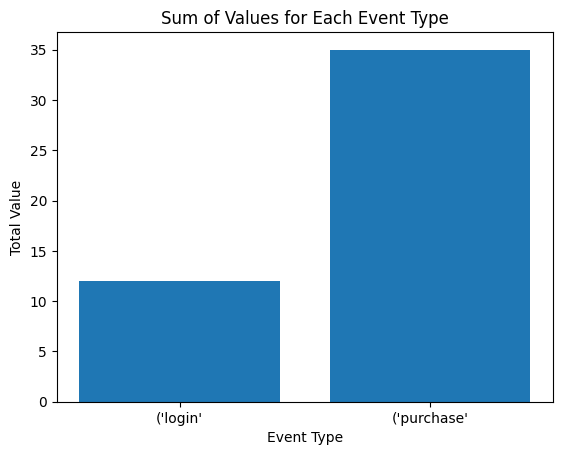

In [ ]:
import matplotlib.pyplot as plt
import re

# Read the results from the output file
with open("output.txt", "r") as file:
    lines = file.readlines()

# Extract events and their sums
events, values = [], []
for line in lines:
    event, value = line.strip().split(',')
    # Remove any non-digit characters from value
    cleaned_value = re.sub(r'\D', '', value)
    events.append(event)
    values.append(int(cleaned_value))

# Plot
plt.bar(events, values)
plt.xlabel('Event Type')
plt.ylabel('Total Value')
plt.title('Sum of Values for Each Event Type')
plt.show()


### Step 5. Visualizing the pipeline

For a more interactive approach, we can use libraries like networkx to represent the pipeline as a directed graph and visualize it. Here's a basic example using our previous pipeline:



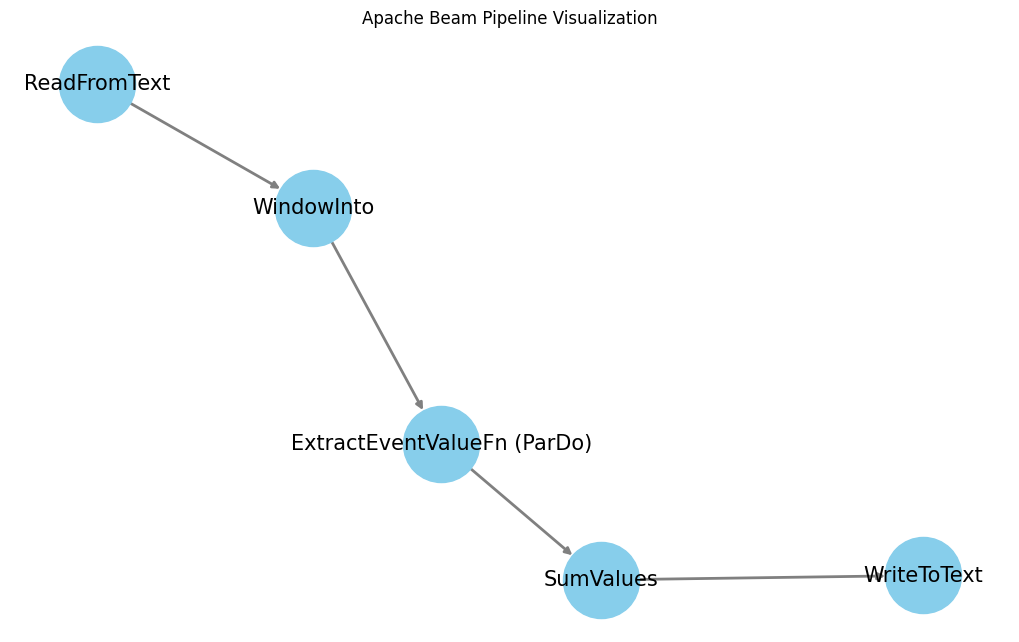

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Nodes represent stages or transforms in the pipeline
nodes = ["ReadFromText", "WindowInto", "ExtractEventValueFn (ParDo)", "SumValues", "WriteToText"]
G.add_nodes_from(nodes)

# Edges represent data flow
edges = [("ReadFromText", "WindowInto"),
         ("WindowInto", "ExtractEventValueFn (ParDo)"),
         ("ExtractEventValueFn (ParDo)", "SumValues"),
         ("SumValues", "WriteToText")]
G.add_edges_from(edges)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=15, width=2, edge_color="gray")
plt.title("Apache Beam Pipeline Visualization")
plt.show()
